# Handling The Class Imbalance Struggle (With Instacart Data)

This lecture is dedicated to the bane of many a classifier's existence, the imbalanced classification problem. [This post](https://svds.com/learning-imbalanced-classes/) is an excellent resource on the topic with great visualizations that I encourage you to read (source for the images). 

When the class of interest occurs rarely in our data, our problems extend beyond just not being able to use accuracy as a scoring metric. Our ML models will be less inclined to pick up signal from rare class samples and treat them more as outliers. This means that our **predicted probabilities for a rare class can be consistently low, making our recall for that class poor**. We're searching for a few rare reds in a huge sea of blue.

![](images/imbalance.png)

It's frequently the case that the rare class is the one we really care about - product reorders, loan defaults, insurance claims, instances of fraud, instances of illness. So instead of just giving up when we're optimizing for something like F1 or ROC AUC and our recall just isn't good enough, we turn to a variety of methods for addressing class imbalance that can let our models provide better recall. Here we'll focus on the binary classification setting, but all of these concepts can be extended to multi-class problems with some added complication. 

### These methods break down into 3 broad categories:

1. **Before model training**: Resampling strategies (oversampling, undersampling)
2. **During model training**: Training with adjusted class weights
3. **After model training**: Adjusting the decision threshold (F1 optimization strategy)

We can try and validate/cross-validate each approach, or combine multiple ones! There is no generally optimal strategy - it's all about having options to try. It is worth noting that options 1 and 2 will distort predicted probability outputs, while option 3 won't have any impact on the ROC AUC. 

**From here on we'll assume that the rare class is the positive class (1)**, and work with the instacart data to see a real-world example (< 10% reorders).

In [1]:
# Setup - as in the feature engineering notebook: same train/test split on randomly selected groups of users  
# You need to have run the feature engineering notebook to create the df_X file (end of nb), it's ~ 150 MBs

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score

path = 'instacart_data_subset/'
df_X = pd.read_csv(path + 'instacart_df_X_features.csv') 
   
np.random.seed(42)
total_users = df_X['user_id'].unique() 
test_users = np.random.choice(total_users, size=int(total_users.shape[0] * .20))

df_X_tr, df_X_te = df_X[~df_X['user_id'].isin(test_users)], df_X[df_X['user_id'].isin(test_users)]

y_tr, y_te = df_X_tr['in_cart'], df_X_te['in_cart']
X_tr, X_te = df_X_tr.drop(['product_id','user_id','latest_cart','in_cart'],axis=1), \
             df_X_te.drop(['product_id','user_id','latest_cart','in_cart'],axis=1), \

## 1. Before Modeling Training - Resampling The Data

Resampling broadly refers to manipulating the training data to have proportionately more of the minority class or less of the majority class than it would organically. This naturally biases the model toward predicting a higher probability for the minority class since it "sees" proportionately more of those observations.

With **oversampling**, the way we do this is by **simply duplicating some of the minority class observations in the training data** (potentially multiple times). This brings the training data closer to a balanced classification problem, and will hopefully give us better results on the unmodified test data by improving our recall without losing too much precision. When using oversampling, we get to choose what the new minority:majority ratio should be and can utilize validation to select this ratio.   

In python, we can use the imblearn package to get a lot of nice resampling functionality. Check out the [imbalanced learn api](http://contrib.scikit-learn.org/imbalanced-learn/stable/api.html) for full detail on what's available.

![](images/resampling.jpg)

We'll go ahead and try oversampling on the instacart data. **It's critical to perform the resampling within the validation loop**. If we oversample on the entire dataset and then do a validation/test split, we'll end up with samples that occur in both train and test, meaning that our test score estimates won't be representative of generalization and will be biased to look much better than they should (we're just memorizing some training data then). The data we test on should always be representative of the original data that we were trying to model. **This extends to CV - when oversampling in CV, you need to oversample once for each training fold** to prevent biasing your validation results. 

In [2]:
# !pip install imblearn
import imblearn.over_sampling

# randomly oversample positive samples to be 40% of targets 
ROS = imblearn.over_sampling.RandomOverSampler(ratio=.4, random_state=42) 
    
X_tr_rs, y_tr_rs = ROS.fit_sample(X_tr, y_tr)

lr = LogisticRegression() 
lr.fit(X_tr, y_tr)

print('Simple Logistic Regression; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(lr.predict(X_te), y_te), roc_auc_score(y_te, lr.predict_proba(X_te)[:,1]))) 

lr_os = LogisticRegression() 
lr_os.fit(X_tr_rs, y_tr_rs)

print('Logistic Regression on Oversampled Train Data; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(lr_os.predict(X_te), y_te), roc_auc_score(y_te, lr_os.predict_proba(X_te)[:,1])))

C:\Users\varru\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


Simple Logistic Regression; Test F1: 0.235, Test AUC: 0.787
Logistic Regression on Oversampled Train Data; Test F1: 0.390, Test AUC: 0.788


We see that this simple oversampling helped us quite a lot. 

An even fancier approach to try is **SMOTE**, synthetic minority oversampling technique. Instead of just duplicating minority samples for training, SMOTE generates "synthetic" minority observations as points in feature space that lie in between different minority samples, with the idea that these should be good representatives of the minority class. Since this is a **distance-based approach**, one should generally be careful about scaling the data, and might find that the technique starts to break down with too many features due to the curse of dimensionality.     

![](images/SMOTE.png)

In [3]:
smote = imblearn.over_sampling.SMOTE(ratio=.4, random_state = 42)
    
X_tr_smote, y_tr_smote = smote.fit_sample(X_tr, y_tr)

lr_smote = LogisticRegression() 
lr_smote.fit(X_tr_smote, y_tr_smote)

print('Logistic Regression on SMOTE Train Data; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(lr_smote.predict(X_te), y_te), roc_auc_score(y_te, lr_smote.predict_proba(X_te)[:,1])))

C:\Users\varru\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


Logistic Regression on SMOTE Train Data; Test F1: 0.391, Test AUC: 0.788


In this case / choice of ratio, SMOTE seems to be working about the same as simple resampling.

We won't try **undersampling** in this notebook, but it can also work quite well. The **balanced bagging** or sandwich-style undersampling techniques can be especially effective, as they make use of the entire dataset available instead of just discarding majority observations (see the post linked at the top). 

## 2. During Model Training - Class Weights

This strategy is arguably the simplest of the 3. Here, when training our model, we give samples from the minority class a **higher contribution to the cost function**. For example, we might give 1 class target samples 2x the weight of 0 class target samples. This forces the model to pay more attention to classifying the minority cases correctly, causing an improvement in recall (and hopefully not too much lost precision). The intuition behind this method is similar to oversampling - in oversampling, the model "sees" the minority class x times more, while with class weight multipliers the model treats each minority sample it "sees" as being worth x times more in the cost function.

Luckily, sklearn makes it easy to do this automatically instead of us rewriting the cost function from scratch :) We can simply pass a `class_weight` argument to any model as below. We can either pass the string `'balanced'` to use a ratio of `common:rare` as the multiplier for the rare class, or pass a dictionary specifying weights `{label1 : weight, label2 : weight2}`.

In my experience, an intermediate multiplier tends to work better than the `balanced` multiplier. But one should always validate/CV the choice of the weights!

In [4]:
lr = LogisticRegression() 
lr_balanced = LogisticRegression(class_weight='balanced')
lr_4x = LogisticRegression(class_weight={1 : 4, 0 : 1})

lr.fit(X_tr, y_tr)
print('Normal Logistic Regression Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(lr.predict(X_te), y_te), roc_auc_score(y_te, lr.predict_proba(X_te)[:,1])))

lr_balanced.fit(X_tr, y_tr)
print('Balanced class weights Logistic Regression Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(lr_balanced.predict(X_te), y_te), roc_auc_score(y_te, lr_balanced.predict_proba(X_te)[:,1])))

lr_4x.fit(X_tr, y_tr)
print('3:1 class weights Logistic Regression Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(lr_4x.predict(X_te), y_te), roc_auc_score(y_te, lr_4x.predict_proba(X_te)[:,1])))

Normal Logistic Regression Test F1: 0.235, Test AUC: 0.787
Balanced class weights Logistic Regression Test F1: 0.358, Test AUC: 0.789
3:1 class weights Logistic Regression Test F1: 0.393, Test AUC: 0.788


Again, this method can help us out a lot.

## 3. After Model Training - Threshold Adjustment to Optimize F1

It's key to remember that predicting 1 when our model spits out $p > .50$ and 0 when $p < .50$ is a **design choice that focuses on accuracy** rather than being something we're locked into. 

If our focus is on a different metric like $F_1$ or an $F_\beta$ variant, 50% could easily be the wrong threshold to use! If we become more aggressive in predicting positives and lower our $p$ threshold, **it's possible that our recall will improve enough to offset our decline in precision**, increasing our $F$ score.

As with everything else, our decision threshold should be something we tune with validation/CV and should not be taken for granted. A nice way to do this is to pull out explicit model probabilities using `predict_proba`, then loop through a range of possible thresholds $p$ and score the corresponding predictions. Then we can grab the max score and the threshold that produced that score.

(Note that this strategy doesn't apply to optimizing ROC AUC, since the ROC curve is already based around a range of decision thresholds)

Logistic Regression Model best F1 score 0.397 at prob decision threshold >= 0.181


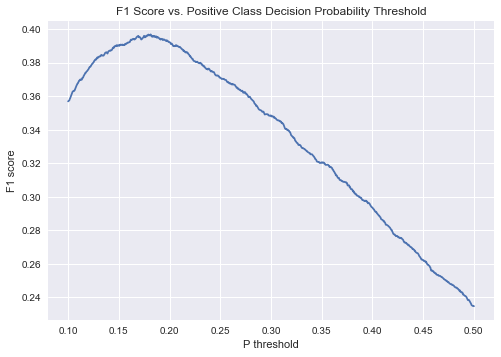

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

X_val, y_val = X_te, y_te # explicitly calling this validation since we're using it for selection

thresh_ps = np.linspace(.10,.50,1000)
model_val_probs = lr.predict_proba(X_val)[:,1] # positive class probs, same basic logistic model we fit in section 2 

f1_scores = []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(model_val_labels, y_val))
    
plt.plot(thresh_ps, f1_scores)
plt.title('F1 Score vs. Positive Class Decision Probability Threshold')
plt.xlabel('P threshold')
plt.ylabel('F1 score')

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Logistic Regression Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

So we've seen that all 3 of the methods we've tried have met with success at improving our F1 score. For more general classification tasks, we may find that the different approaches vary more in their level of success, so it is often worth trying all of them. 

## Exercises

In [6]:
# For strategy 1, loop over a wider range of upsampling ratios, using validation to select an optimal ratio


In [7]:
# For strategy 2, loop over a wider range of class weight multipliers, using validation to select an optimal multiplier


In [8]:
# Combine multiple strategies! What happens if you upsample and use threshold adjustments, or use class weights then 
# threshold adjustments? Experiment until you can beat the .381 validation F1 score above.
